<style>
.noborder td, .noborder th, .noborder table {
    border: none !important;
}
</style>

<table id="top" class="noborder" style="width:100%; border-collapse:collapse;">
  <tr>
    <td style="text-align:left; width:33%;">
      <a href="./02_clustering.ipynb" title="Clustering">&lt; Previous</a>
    </td>
    <td style="text-align:center; width:33%;">01</td>
    <td style="text-align:right; width:33%;">
    </td>
  </tr>
</table>

# 🎵 Spotify Cluster Model Training & Selection
---
This notebook trains **three different machine learning models** (Random Forest, Gradient Boosting, and XGBoost), compares their performance, selects the best-performing model based on accuracy, and saves it for use in a Streamlit app.


## 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier

import joblib
from pathlib import Path

## 2. Define Paths

In [2]:
CURRENT_DIR = Path.cwd()
MODEL_PATH = CURRENT_DIR.parent / 'models/best_spotify_model.pkl'
CLUSTER_DATA = CURRENT_DIR.parent / 'data/labelled/clusters_k10_labels.csv'

MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)

## 3. Load and Inspect Data

In [3]:
df = pd.read_csv(CLUSTER_DATA)
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], errors='ignore')

print('Data Shape:', df.shape)
df.head()

Data Shape: (109607, 21)


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,cluster
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,2
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,9
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,9
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,9
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,9


## 4. Feature Selection

In [4]:
features = [
    'danceability', 'energy', 'key', 'loudness', 'mode',
    'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo'
]

target = 'cluster'

X = df[features]
y = df[target]

## 5. Train/Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 6. Train Multiple Models

In [6]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softmax',
        num_class=y.nunique(),
        eval_metric='mlogloss',
        random_state=42
    )
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

Random Forest Accuracy: 0.9370
Gradient Boosting Accuracy: 0.9251
XGBoost Accuracy: 0.9454


## 7. Select Best Model

In [7]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Best Accuracy: {results[best_model_name]:.4f}")


Best Model: XGBoost
Best Accuracy: 0.9454


## 8. Evaluation of Best Model

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2471
           1       0.96      0.98      0.97      1220
           2       0.96      0.96      0.96      2360
           3       0.97      0.98      0.98      3160
           4       0.79      0.71      0.75      1472
           5       0.95      0.96      0.96      1294
           6       0.97      0.96      0.97      1229
           7       0.96      0.97      0.96      3162
           8       0.96      0.97      0.97      2221
           9       0.95      0.95      0.95      3333

    accuracy                           0.95     21922
   macro avg       0.94      0.94      0.94     21922
weighted avg       0.94      0.95      0.94     21922



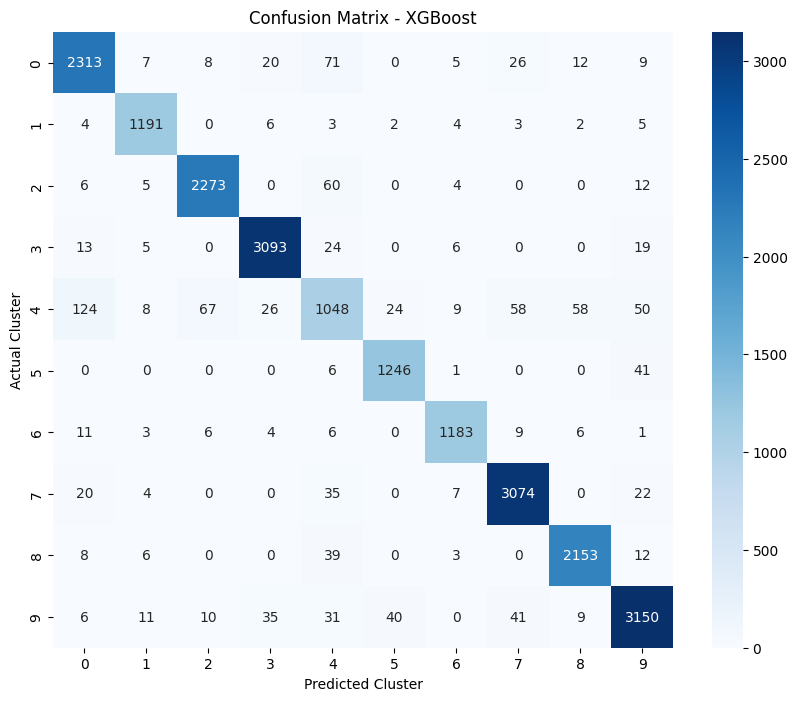

In [8]:
y_best_pred = best_model.predict(X_test)

print(classification_report(y_test, y_best_pred))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_best_pred), annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual Cluster')
plt.xlabel('Predicted Cluster')
plt.show()

## 9. Save Best Model

In [9]:
joblib.dump(best_model, MODEL_PATH)
print(f"Best model ({best_model_name}) saved to: {MODEL_PATH}")

Best model (XGBoost) saved to: c:\Users\LENOVO\Documents\DAandAI-CodeInstitute\hackothon4\spotify-recommendation-system\models\best_spotify_model.pkl


## ✅ Summary
- Trained **Random Forest**, **Gradient Boosting**, and **XGBoost**
- Compared models using accuracy
- Automatically selected and saved the best-performing model
- Ready for integration with the Streamlit dashboard

---
<style>
.noborder td, .noborder th, .noborder table {
    border: none !important;
}
</style>

<table class="noborder" style="width:100%; border-collapse:collapse;">
  <tr>
    <td style="text-align:left; width:33%;">
      <a href="./02_clustering.ipynb" title="Clustering">&lt; Previous</a>
    </td>
    <td style="text-align:center; width:33%;">01</td>
    <td style="text-align:right; width:33%;">
    </td>
  </tr>
</table>
<p style="text-align:center;">
  <a href="#top">⬆ Back to top</a>
</p>